# Shapley Values and Shapley Cell Detector for Explaining Outliers in Supervised Machine Learning

While MACAU excels at detecting anomalies, outliers, or novelties—terms we use interchangeably in this context—in supervised machine learning, it is sometimes insufficient to merely detect these novelties; it is also valuable to elucidate why they are considered novel. Providing explanations for the novelty of a particular sample encourages further analysis, akin to the common practice in machine learning of explaining model predictions through techniques such as Shap values, rather than relying solely on black-box methods.

MACAU has been enhanced to incorporate Shapley values for outlier explanations, along with the Shapley Cell Detector (SCD) algorithm initially introduced in [1], implemented within leaf-wise models. In MACAU, Shapley values for outlier detection manifest as feature attributions indicating the likelihood of a sample being an outlier, with the sum of all feature attributions equating to the total novelty. The SCD algorithm essentially generates counterfactuals based on Shapley values, revealing the extent to which a sample's feature values deviate from the norm on the original scale, facilitating a clearer understanding of why a particular sample is considered novel.

This demonstrator showcases the novelty explanation capabilities in a simple regression scenario, employing the California Housing dataset. Rather than arranging an extrapolation case, the aim is to model the inherent novelty present in the data.

[1] Marcus Mayrhofer, Peter Filzmoser, Multivariate outlier explanations using Shapley values and Mahalanobis distances, Econometrics and Statistics, 2023, ISSN 2452-3062, https://doi.org/10.1016/j.ecosta.2023.04.003.

## Demonstration

First, we declare the necessary imports, followed by loading the data and splitting it into training and test sets in a 50/50 manner. Initially, a LightGBM regression model is identified, followed by fitting MACAU as usual. After fitting the necessary models, MACAU is utilized to predict the test set and obtain Shapley outlier explanations, as well as SCD values for visualization and analysis.

In [1]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.tri import Triangulation
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import lightgbm
from macau.MACAU import MACAU

In [2]:
X, Y = fetch_california_housing(return_X_y = True, as_frame = True)    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

In [3]:
lgbm_model = lightgbm.LGBMRegressor(boosting_type = 'rf',
                                    importance_type = 'gain',
                                    n_estimators = 100,
                                    max_depth = -1,
                                    colsample_bytree = 1.0,
                                    subsample_freq = 1,
                                    subsample = 0.8,
                                    reg_alpha = 0,
                                    reg_lambda = 0,
                                    verbose = -1,
                                    num_leaves = 31,
                                    min_child_samples = 20,
                                    n_jobs = 10)

lgbm_model.fit(X_train, Y_train)
macau = MACAU(lgbm_model).fit(X_train, Y_train) 
pred = macau.predict(X_test)

# Shapley values for outlier explanations
novelty_shap_explanations = macau.novelty_explanations(X_test, shap_values = True)

# SDC values
novelty_explanations = macau.novelty_explanations(X_test, shap_values = False)

Shapley values for outlier explanations are akin to typical Shap values employed for explaining model predictions. However, in this scenario, they elucidate the feature attributions to novelty rather than the regressed value. Instead of directly utilizing raw Shapley values to model Mahalanobis distance, MACAU transforms these values into probabilities. Consequently, the Shapley values signify each feature's contribution to the total novelty, which is expressed as a probability.

Below, feature attributions to novelty are depicted feature by feature and visualized on a 2D map of California. From this visualization, one can discern which features contributed to the novelty. Armed with this information, when novelty is high, one can gain a clearer understanding of why it is high.

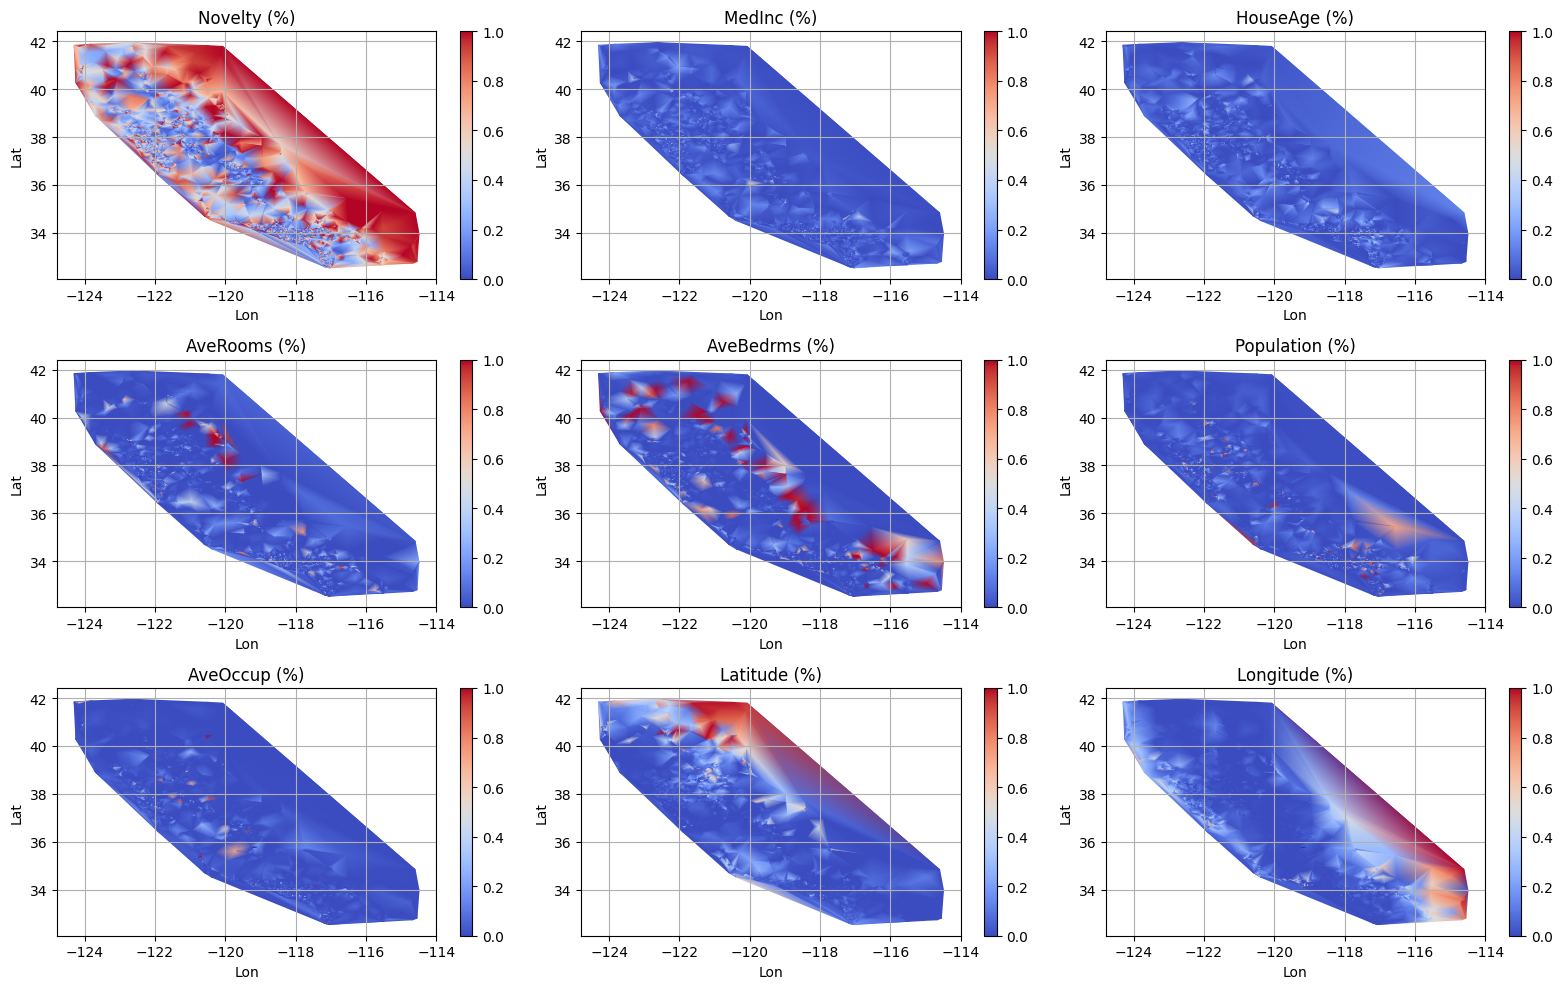

In [11]:
explanations = novelty_shap_explanations

tri = Triangulation(X_test['Longitude'], X_test['Latitude'])

fig, ax = plt.subplots(figsize = (16, 10), ncols = 3, nrows = 3)
ax = ax.ravel()
ax[0].set_title('Novelty (%)')
ax[0].set_xlabel('Lon')
ax[0].set_ylabel('Lat')
    
contour = ax[0].tripcolor(tri, pred.iloc[:, 2], vmin = 0.0, vmax = 1.0, shading = 'gouraud', cmap = 'coolwarm')
fig.colorbar(contour, ax = ax[0])
for idx, col in enumerate(X_test.columns):
    ax[idx + 1].set_title(f'{col} (%)')
    ax[idx + 1].set_xlabel('Lon')
    ax[idx + 1].set_ylabel('Lat')
    contour = ax[idx + 1].tripcolor(tri, explanations[0][col], vmin = 0.0, vmax = 1.0, shading = 'gouraud', cmap = 'coolwarm')
    fig.colorbar(contour, ax = ax[idx + 1])

for axis in ax:
    axis.grid()
fig.tight_layout()

While Shapley values for outlier explanation illustrate the feature attributions to novelty on a scale of probabilities, the SCD depicted below reveals the reasons for novelty in the original feature scale. If a value is positive for a certain feature, it indicates that the sample possesses a feature value that is excessively high, and reducing it would decrease the novelty, and the other way around in case of negative values. Essentially, the values for each sample represent counterfactuals, indicating how much should be subtracted from the original sample to return to a non-novel area in the space.

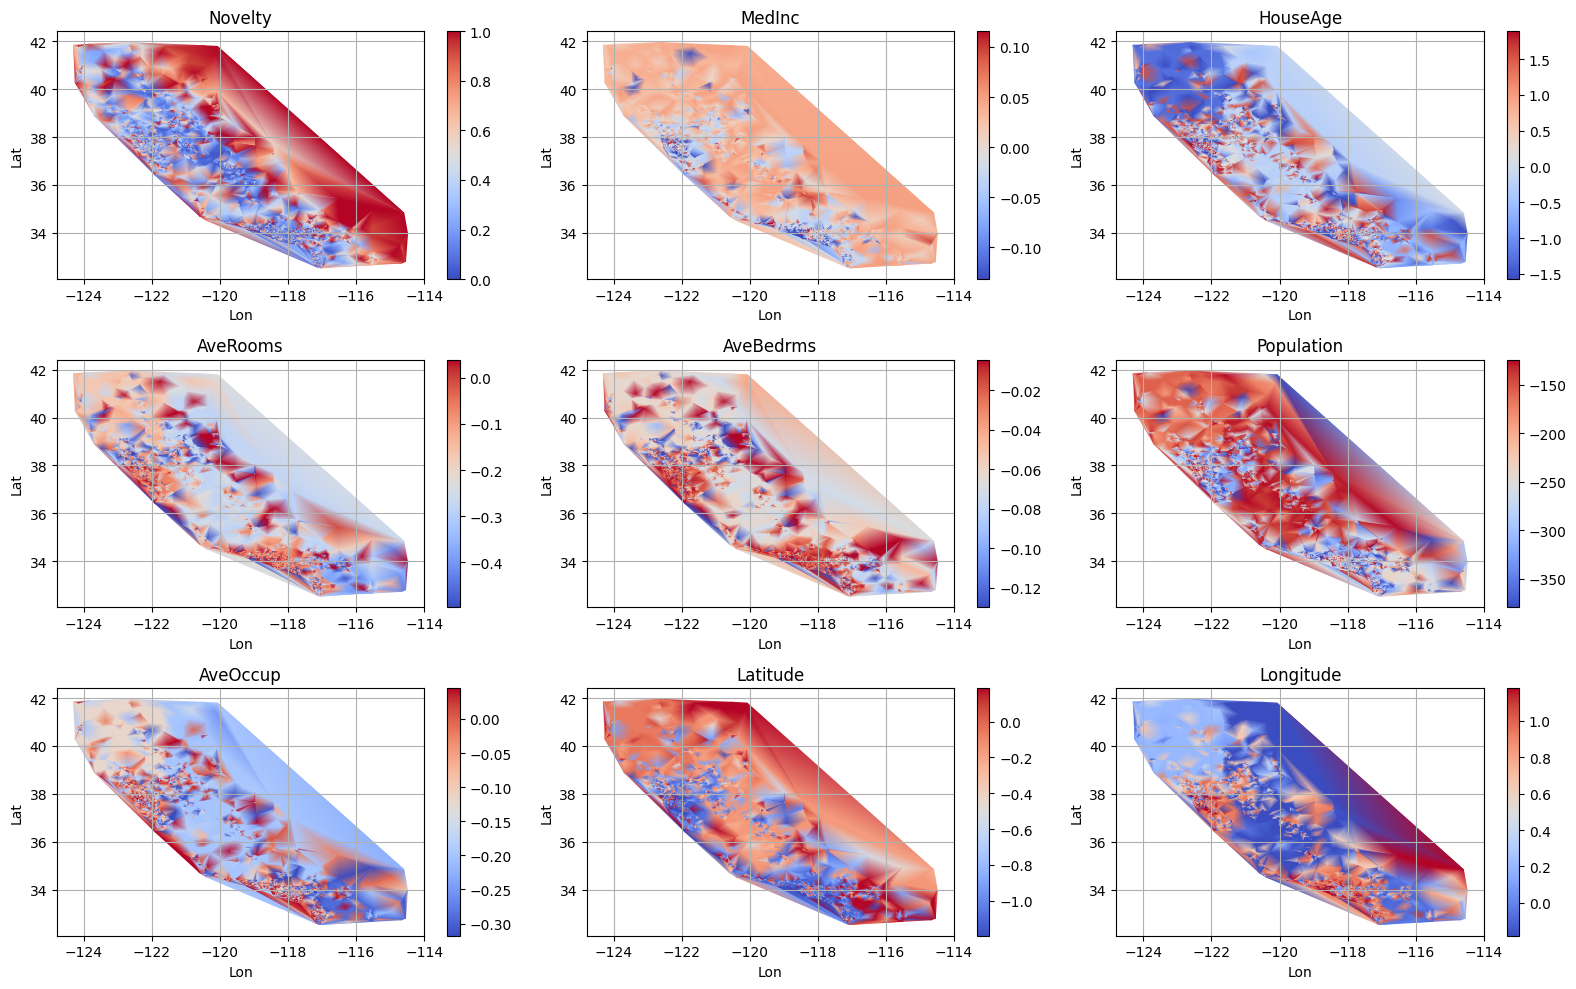

In [12]:
explanations = novelty_explanations

tri = Triangulation(X_test['Longitude'], X_test['Latitude'])

fig, ax = plt.subplots(figsize = (16, 10), ncols = 3, nrows = 3)
ax = ax.ravel()
ax[0].set_title('Novelty')
ax[0].set_xlabel('Lon')
ax[0].set_ylabel('Lat')

contour = ax[0].tripcolor(tri, pred.iloc[:, 2], vmin = 0.0, vmax = 1.0, shading = 'gouraud', cmap = 'coolwarm')
fig.colorbar(contour, ax = ax[0])
for idx, col in enumerate(X_test.columns):
    ax[idx + 1].set_title(f'{col}')
    ax[idx + 1].set_xlabel('Lon')
    ax[idx + 1].set_ylabel('Lat')
    contour = ax[idx + 1].tripcolor(tri, explanations[0][col], vmin = explanations[0][col].quantile(0.05), vmax = explanations[0][col].quantile(0.95), shading = 'gouraud', cmap = 'coolwarm')
    fig.colorbar(contour, ax = ax[idx + 1])

for axis in ax:
    axis.grid()
fig.tight_layout()

## Conclusions

With the inclusion of Shapley values for outlier explanations and SCD, one can now gain a deeper understanding of why a particular sample is considered novel, rather than solely relying on this determination. Through Shapley values for outlier explanations, it becomes straightforward to discern the precise contribution of each feature to the novelty, as expressed in probabilities, where the sum of these feature attributions equates to the total novelty. Meanwhile, SCD aids in comprehending why a sample is novel by considering explanations in the original feature scale.